In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from collections import Counter

### Preparing data

In [186]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

DICT_HP = ['Earth', 'Europa', 'Mars', 'nan']
DICT_DEST = ['TRAPPIST-1e', 'PSO J318.5-22','55 Cancri e', 'nan']
DICT_CABIN = 'ABCDEFGT'
NUMERIC_COLUMNS = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

NAMES1, NAMES2 = [], []
for name in df_train['Name']:
  if name is np.nan: continue
  parts = name.split()
  assert len(parts)==2
  NAMES1.append(parts[0])
  NAMES2.append(parts[1])  
NAMES1 = [x[0] for x in  Counter(NAMES1).most_common(15)]
NAMES2 = [x[0] for x in  Counter(NAMES2).most_common(15)]

def one_hot_encode(value, dictt, verify=True):
  value = str(value)
  if verify:
    assert value in dictt
  return [int(value==dictt[i]) for i in range(len(dictt))]

def encode_bool_with_nan(value):
  if value is np.nan: return [0,0]
  if value is True: return [1,0]
  if value is False: return [0,1]
  assert False

def encode_cabin(cabin):
  if cabin is np.nan:
    return [1] + [0]*10
  parts = cabin.split('/')
  assert len(parts)==3
  assert parts[2] in 'SP'
  return [0] + one_hot_encode(parts[0], DICT_CABIN) + [int(parts[1])] + [1 if parts[2]=='S' else 0]
  
  
def row_to_numbers(row):
  # Add all numerical features.
  ans = [row['Age'],row['RoomService'],row['FoodCourt'],row['ShoppingMall'],row['Spa'], row['VRDeck']]
  
  # Boolean features.
  ans += encode_bool_with_nan(row['CryoSleep'])
  ans += encode_bool_with_nan(row['VIP'])
  
  # Categorical features.
  ans += one_hot_encode(row['HomePlanet'], DICT_HP)
  ans += one_hot_encode(row['Destination'], DICT_DEST)
  ans += encode_cabin(row['Cabin'])

  # Encode most common names.
  name = row['Name']
  if name is not np.nan:
    name_parts = name.split()
    ans += one_hot_encode(name_parts[0], NAMES1, verify=False)
    ans += one_hot_encode(name_parts[1], NAMES1, verify=False)
  else:
    ans += [0]*(len(NAMES1) + len(NAMES2))
  
  # Ignore Name for now.   
  return ans
  
  
def df_to_x(df):
  for col in NUMERIC_COLUMNS:
    df[col] = df[col].fillna(df[col].median())
  ans = []
  for _, row in df.iterrows():
    ans.append(row_to_numbers(row))
  return np.array(ans)

def df_to_y(df):
  return np.array([row['Transported'] for _, row in df.iterrows()])


X_train_full = df_to_x(df_train)
y_train_full = df_to_y(df_train)
X_test = df_to_x(df_test)  
print(X_train_full.shape, y_train_full.shape, X_test.shape)

(8693, 59) (8693,) (4277, 59)


In [187]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.05, random_state=0)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(8258, 59) (8258,) (435, 59) (435,)


### Training

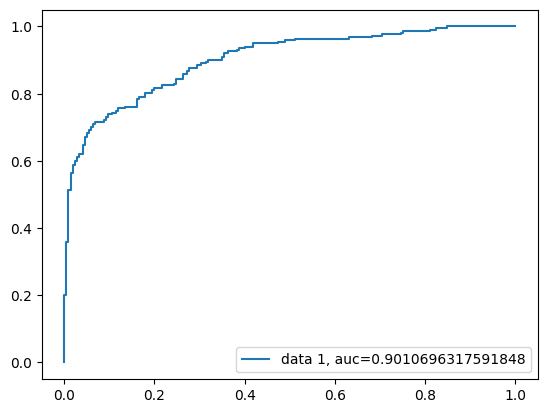

In [188]:
dtrain_reg = xgb.DMatrix(X_train, y_train)
dval_reg = xgb.DMatrix(X_val)

params = {
  "objective": "reg:logistic",
  "eval_metric": "error",
  "tree_method": "auto",
}

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=100,
)

y_pred_proba = model.predict(dval_reg)
fpr, tpr, _ = metrics.roc_curve(y_val, y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Selecting best threshold

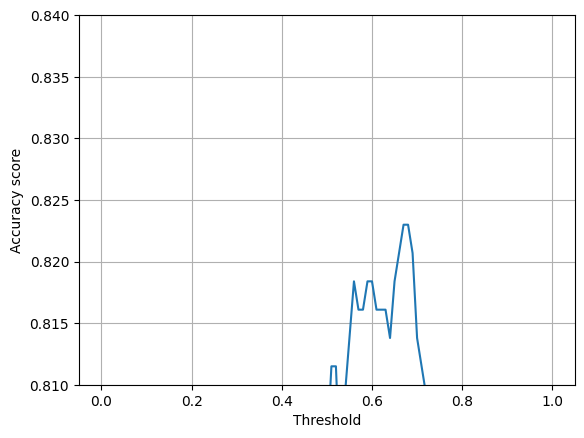

Optimal treshold: 0.67 best accuracy: 0.8229885057471265


In [189]:
tss = np.linspace(0,1,101)
acc_chart = [metrics.accuracy_score(y_val, y_pred_proba > ts) for ts in tss]
plt.plot(tss, acc_chart)
plt.ylim([0.81, 0.84])
plt.grid()
plt.xlabel('Threshold')
plt.ylabel('Accuracy score')
plt.show()
i_max = np.argmax(acc_chart)
print("Optimal treshold:", tss[i_max], "best accuracy:", acc_chart[i_max])

## Prediction on test data

In [190]:
y_ans_proba = model.predict(xgb.DMatrix(X_test))
y_ans = y_ans_proba > 0.5
df_ans = pd.DataFrame({"PassengerId":df_test['PassengerId'], "Transported": y_ans})
df_ans.to_csv('ans.csv',index=False)